In [2]:
!pip install -Uqq fastai duckduckgo_search # u-  upgrade q-quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


### Searching for images in DuckDuckGo

In [3]:
# from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
#     return L(ddg_images(term, max_results=max_images)).itemgot('image')
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')


In [4]:
urls = search_images('city ', max_images=1)
urls[0]

Searching for 'city '


'https://upload.wikimedia.org/wikipedia/commons/8/84/New_York_City_skyline.jpg'

Searching for 'image of a city'


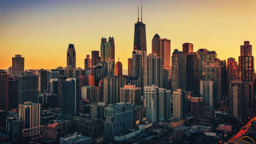

In [5]:
from fastdownload import download_url

from fastai.vision.all import *
download_url(search_images('image of a city', max_images=1)[0], 'city.jpg', show_progress=False)
Image.open('city.jpg').to_thumb(256,256)

Searching for 'image of a village'


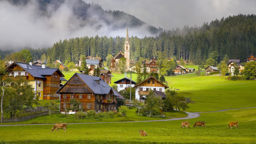

In [6]:
download_url(search_images('image of a village', max_images=1)[0], 'village.jpg', show_progress=False)
Image.open('village.jpg').to_thumb(256,256)

Searching for 'image of a farm land'


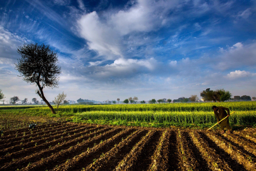

In [7]:
download_url(search_images('image of a farm land', max_images=1)[0], 'farmland.jpg', show_progress=False)
Image.open('farmland.jpg').to_thumb(256,256)

Searching for 'image of a body of water'


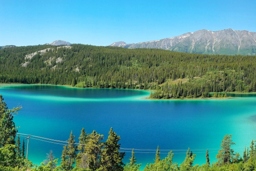

In [8]:
download_url(search_images('image of a body of water', max_images=1)[0], 'waterbody.jpg', show_progress=False)
Image.open('waterbody.jpg').to_thumb(256,256)

### Creating a Dataset

In [9]:
searches = 'image of a body of water','image of a city','image of a village','image of a farm land'
path = Path('satellite_map_classifier')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} '))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} '))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} '))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'image of a body of water '


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Searching for 'image of a body of water '
Searching for 'image of a body of water '
Searching for 'image of a city '
Searching for 'image of a city '
Searching for 'image of a city '
Searching for 'image of a village '
Searching for 'image of a village '
Searching for 'image of a village '
Searching for 'image of a farm land '
Searching for 'image of a farm land '
Searching for 'image of a farm land '


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

### Creating DataBlocks

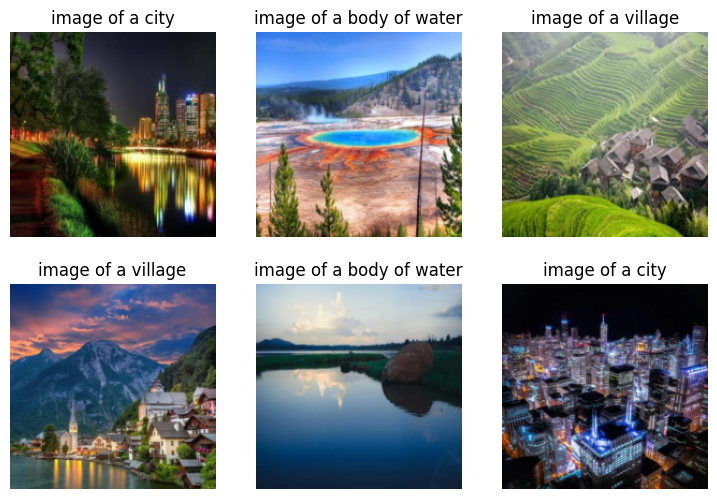

In [11]:
img = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # input - ImageBlock, output- CategoryBlock
    get_items=get_image_files,  
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, # get the correct label of the photo from the parent folder
    item_tfms=[Resize(192, method='squish')] # resize and squish to reduce computation time
)
dls = img.dataloaders(path, bs=32) # batch 32

dls.show_batch(max_n=6)

### Training ResNet34

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.767900,0.367792,0.185714,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.331835,0.059602,0.014286,00:45
1,0.178935,0.028083,0.000000,00:45
2,0.123527,0.026378,0.000000,00:45


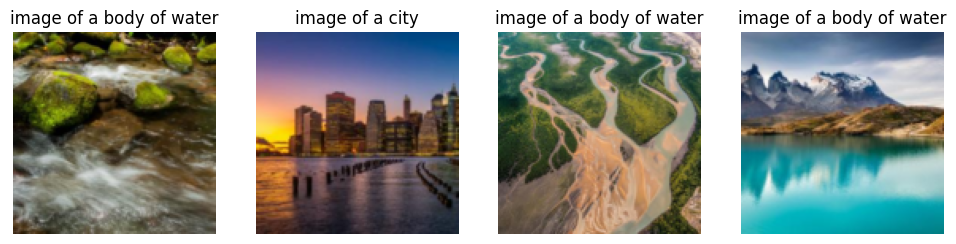

In [15]:
img = img.new(item_tfms=Resize(128))
dls = img.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Testing

In [16]:
location,_,probs = learn.predict(PILImage.create('waterbody.jpg'))
print(f"This is a: {location}.")
print(f"Probability: {probs[0]:.4f}")

This is a: image of a body of water.
Probability: 0.9993
